# Plots for the paper

In [1]:
from data_import import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from plotting import *

device = 'cuda:0'

df_orig = load_result_table('feeds/phase_diagram_T64').reset_index()
df_orig = df_orig[df_orig['epoch']==499]
figure_dir = FIGURE_DIR 

df = df_orig.groupby(CONFIG_COLS).mean(numeric_only=True).reset_index()
df_std = df_orig.groupby(CONFIG_COLS).std(numeric_only=True).reset_index()

                           name  _step    val_acc     _runtime  val_loss  \
40              rich-sound-1432  500.0  94.219702  1254.684850  0.153975   
44           polished-surf-1428  500.0  98.059462  1223.191868  0.072469   
48            hopeful-surf-1424  500.0  98.557657  1234.753695  0.076387   
52             sleek-field-1420  500.0  96.463717  1239.446829  0.146970   
55    resilient-wildflower-1417  500.0  88.762824  1222.627018  0.442263   
59         usual-armadillo-1413  500.0  69.845176  1234.132040  0.916680   
63           charmed-disco-1409  500.0  43.116927  1225.352758  1.476472   
309          stellar-disco-1163  500.0  96.003515  1288.571615  0.121839   
316         lucky-capybara-1156  500.0  97.509500  1295.309000  0.080772   
322             absurd-dew-1150  500.0  97.943105  1294.767126  0.090064   
327            desert-bush-1145  500.0  95.138204  1290.020306  0.165580   
334           spring-totem-1138  500.0  87.317631  1294.435409  0.495906   
340         

wandb:   1 of 1 files downloaded.  


8 [4, 8, 32]
feeds/phase_diagram_T64/dark-dream-233-model:v0 | val_acc: 81.533


wandb:   1 of 1 files downloaded.  


16 [4, 8, 32]
32 [4, 8, 32]
feeds/phase_diagram_T64/bright-bird-850-model:v0 | val_acc: 97.219


wandb:   1 of 1 files downloaded.  


64 [4, 8, 32]
128 [4, 8, 32]


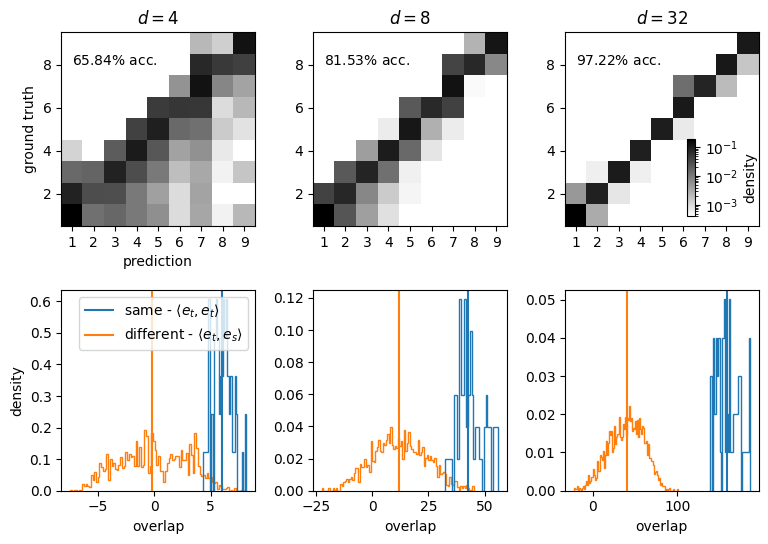

In [2]:
from memory_exp import HistogramDatasetSampleBackward, HistogramDatasetSampleForward, HistogramDatasetSampleBackwardWithBOS
from data_import import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from memory_exp import *
import matplotlib as mpl

bright_distinguishable_colors = plt.cm.tab20.colors
bright_distinguishable_colors = {d: c for c, d in zip(bright_distinguishable_colors,df_orig.model_dim.unique())}

fig, axes = plt.subplots(2,3,figsize=(9,6))
model_config = MODELS['dot+sftm']
k = df_orig
p = 64
T = 64
a = k[(k.attention_input == model_config['attention_input'])
            & (k.no_softmax == model_config['no_softmax']) 
            & (k.dataset_type == model_config['dataset'])
            & (k.p == p)]
print(a)
ds = [4,8,32]
ax_idx_d = {d: i for i, d in enumerate(ds)}
for d, g in a.reset_index().groupby('model_dim'):
    print(d,ds)
    if d not in ds:
        continue
    idx = ax_idx_d[d]
    # find the row with the highest validation accuracy
    g = g.set_index('name').sort_values('val_acc',ascending=True)
    config = g.iloc[0]
    model, word_embeddings = load_model(config)
    dataset_cls = {'forward': HistogramDatasetSampleForward,
                    'backward': HistogramDatasetSampleBackward,
                    'backward_BOS': HistogramDatasetSampleBackwardWithBOS}[config['dataset_type']]
    val_dataset = dataset_cls(config['seq_len'], config['T'], int(0.3 * config['num_samples']))
    train_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    n_classes = config['seq_len']+1
    activ = []
    ys = []
    outputs = []
    attn_probs = []
    mixeds = []
    Xs = []
    preds = []
    acc = 0
    val_loss = 0
    counter = word_embeddings.sum(axis=0)/T
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        
        # compute accuracy
        pred = output.argmax(axis=-1)
        preds.append(pred.detach().cpu().numpy())
        ys.append(y.detach().cpu().numpy())
        Xs.append(X.detach().cpu().numpy())

    preds = np.concatenate(preds).flatten()
    ys = np.concatenate(ys).flatten()
    
    confusion = np.zeros((config['seq_len']+1,config['seq_len']+1))
    for i in range(len(ys)):
        confusion[ys[i],preds[i]] += 1

    im = axes[0,idx].imshow(confusion/confusion.sum(), origin='lower', cmap='binary',norm=mpl.colors.LogNorm())
    
    
    axes[0,idx].set_xlim(0.5,config['seq_len']-0.5)
    axes[0,idx].set_ylim(0.5,config['seq_len']-0.5)
    axes[0,idx].set_xticks(range(1, config['seq_len']))
    
    
    
    word_embeddings = word_embeddings #/ torch.norm(word_embeddings,dim=-1).unsqueeze(-1)
    outer = word_embeddings @ word_embeddings.T

    outer = outer.flatten()
    mask = (np.eye(word_embeddings.shape[0]) == 0).flatten()
    axes[1,idx].hist(outer[mask].detach().numpy().flatten(),bins=100,histtype='step',color='tab:orange',density=True)
    axes[1,idx].hist(outer[~mask].detach().numpy().flatten(),bins=30,histtype='step',color='tab:blue',density=True)
    axes[1,idx].axvline(outer[mask].median().item(),color='tab:orange')
    axes[1,idx].axvline(outer[~mask].median().item(),color='tab:blue')
    axes[1,idx].set_xlabel('overlap')
    
    
    axes[0,idx].text(1, 8, f'${config["val_acc"]:.2f}\%$ acc.')
    axes[0,idx].set_title(f'$d={d}$')
    axes[0,0].set_xlabel('prediction')

axes[0,0].set_ylabel('ground truth')
axes[1,0].set_ylabel('density')
    

    
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cax = axes[0,-1].inset_axes([0.63,0.05,0.04,0.4])

# adjust the margin between the subplots to be smaller
fig.subplots_adjust(wspace=0.3,hspace=0.3)
# Add a colorbar to the inset_axes
cbar = plt.colorbar(im, cax=cax, label='density')
axes[1,0].plot([],[],label=r'same - $\langle e_t, e_t \rangle$',color='tab:blue')
axes[1,0].plot([],[],label=r'different - $\langle e_t, e_s \rangle$',color='tab:orange')
axes[1,0].legend()
plt.savefig(figure_dir / 'changing-d-for-fixed-p-dotsftm_final.pdf',bbox_inches='tight')